###Exemplo retirado do livro A First Course in Finite Element Method 4ª Edição - Daryl Logan Capítulo 16 exemplo 16.3

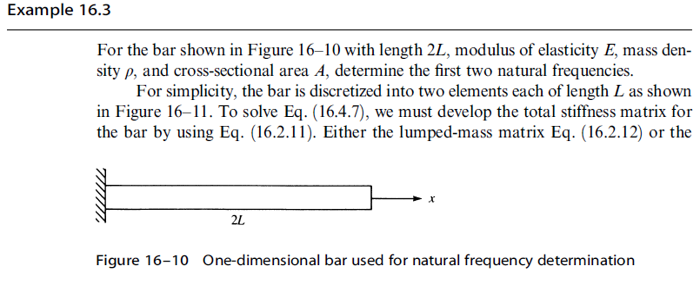

In [26]:
import requests
from PIL import Image
from io import BytesIO

file_id = '1-mqco3VqqxdYjRF4P6HScSmuR-sV5QUI'
url = f'https://drive.google.com/uc?export=view&id={file_id}'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

new_size = (700, 300)  # (largura, altura) em pixels
img_resized = img.resize(new_size)

display(img_resized)
#https://drive.google.com/file/d/1-mqco3VqqxdYjRF4P6HScSmuR-sV5QUI/view?usp=drive_link

###**Considerações, o exercício resolvido no livro vai pelo método de massas concentradas por questões de cálculo. Nesta resolução a matriz de massa é consistente**

###Análise de frequências naturais

O código implementa a solução do problema de autovalor generalizado usando a formulação do Elemento Finito 1D de barra.

$$[K]−ω^2{M}{ϕ}={0}$$






###Definições iniciais do problema

Importações: A linha import numpy as np traz a biblioteca `NumPy`, from `scipy.linalg` `import eig` importa a função `eig` da `SciPy`, que é o solver numérico para o problema de autovalor generalizado (encontrar autovalores e autovetores).

* Parâmetros Físicos e Geométricos:

Definimos as variáveis $E$, $ρ$, $A$ e $L$ barra com os valores do livro ($E=30×10^6$, $ρ=0.00073$, $L_{barra} =100$).

* Discretização:

As variáveis `num_elementos = 2` e `num_nos = 3` definem a malha. O comprimento de cada elemento (`l_elemento`) é calculado, formalizando a Discretização MEF.

###Matrizes do elemento

* Matriz de Rigidez (`k_elem`):

O código calcula a matriz:  

$$[k] = \frac{EA}{L}
\begin{bmatrix}
1 & -1 \\
-1 & 1
\end{bmatrix}
$$

Matriz de rigidez axial do elemento de barra 1D, derivada da Teoria do Elemento Finito por meio do princípio da mínima energia potencial.

* Matriz de Massa Consistente (`m_elem`):

O código implementa:

$$[k] = \frac{ρAl}{6}
\begin{bmatrix}
2 & 1 \\
1 & 2
\end{bmatrix}
$$

A matriz distribui a inércia do elemento de forma consistente com as funções de forma. É a formulação padrão da Análise Dinâmica MEF.

###Matrizes Globais [K] e [M]

* Inicialização:

As matrizes `K_global` e `M_global` são inicializadas como matrizes $3×3$ de zeros.

* Loop de Montagem:

 O loop `for` itera sobre os elementos. A operação `K_global[i:i+2, i:i+2] += k_elem` realiza a Superposição de Efeitos. Cada matriz de elemento $2×2$ é adicionada à submatriz global correspondente. Por exemplo, o Nó 2 (índice 1) recebe a contribuição de rigidez e massa do Elemento 1 e do Elemento 2, resultando em um valor maior e acoplado na sua posição.

###Condições de contorno e Redução de Matrizes

* Restrição:

A barra está engastada no Nó 1 (índice 0), o que implica $u_1=0$. Os GDLs livres são apenas $d_2$ e $d_3$(índices 1 e 2).

Redução:
As linhas `K_reduzida = K_global[np.ix_(gdl_livres, gdl_livres)]` e `M_reduzida` realizam a Partição de Matriz. A função `np.ix_` extrai as submatrizes correspondentes aos GDLs livres, impondo a condição de contorno de deslocamento nulo. O sistema $3×3$ é reduzido para um sistema $2×2$ resolvível.

###Obtenção dos Autovalores

* Solver de Autovalor:

A linha `lambdas, _ = eig(K_reduzida, M_reduzida)` executa a solução. A função $eig$ retorna os autovalores $λ$ que, no contexto de vibração, são $λ=ω_2$ (frequência angular ao quadrado).

* Frequência Natural:

A linha `frequencias_rad_s = np.sort(np.sqrt(np.real(lambdas)))` calcula a frequência ω tirando a raiz quadrada da parte real do autovalor, $ω=λ$ . O resultado é ordenado para obter $ω_1$ e $ω_2$ sequencialmente.

* Solução Exata:

O código também calcula `omega_1_exato` e `omega_2_exato` usando a fórmula analítica clássica para uma barra engastada-livre, que serve como referência de validação do resultado do MEF.

In [32]:
import numpy as np
from scipy.linalg import eig

# Parâmetros Fornecidos pelo Livro (para L=50 in, 2L=100 in)
E = 30e6       # psi (Módulo de Elasticidade)
rho = 0.00073  # lbs^2/in^4 (Densidade de Massa)
A = 1.0        # in^2 (Área - assumindo 1.0)
L_barra = 100.0# in (Comprimento total 2L)

# Configuração do MEF
num_elementos = 2
num_nos = num_elementos + 1
l_elemento = L_barra / num_elementos

# 1. Matrizes do Elemento (Massa CONSISTENTE)
# [k] = (EA/l) * [[1, -1], [-1, 1]]
k_elem = (E * A / l_elemento) * np.array([
    [1, -1],
    [-1, 1]
])

# [m] = (rho*A*l/6) * [[2, 1], [1, 2]] <-- CONSISTENTE
m_elem = (rho * A * l_elemento / 6) * np.array([
    [2, 1],
    [1, 2]
])

# 2. Montagem Global [K] e [M]
K_global = np.zeros((num_nos, num_nos))
M_global = np.zeros((num_nos, num_nos))

for e in range(num_elementos):
    i = e
    K_global[i:i+2, i:i+2] += k_elem
    M_global[i:i+2, i:i+2] += m_elem

# 3. Aplicação das Condições de Contorno (Engaste no Nó 1/índice 0)
gdl_livres = [1, 2]
K_reduzida = K_global[np.ix_(gdl_livres, gdl_livres)]
M_reduzida = M_global[np.ix_(gdl_livres, gdl_livres)]

# 4. Solução do Problema de Autovalor
lambdas, _ = eig(K_reduzida, M_reduzida)
frequencias_rad_s = np.sort(np.sqrt(np.real(lambdas)))

omega_1_mef = (frequencias_rad_s[0])/(2*np.pi)
omega_2_mef = (frequencias_rad_s[1])/(2*np.pi)

# 5. Solução Analítica Exata para comparação
# Fórmula: omega_n = ((2n - 1) * pi / (4L)) * sqrt(E/rho) - (n=1, 2, 3...)
L_total_barra = 100.0 # 2L do problema
C = np.sqrt(E / rho) # Velocidade da onda
omega_1_exato = ((np.pi / (2 * L_total_barra)) * C)/(2*np.pi)
omega_2_exato = ((3 * np.pi / (2 * L_total_barra)) * C)/(2*np.pi)

# Resultados
print("--- Análise Modal de Barra (2 Elementos, Matriz de Massa Consistente) ---")
print(" ")
print(f"Parâmetros: E={E:.2e}, rho={rho}, L_barra={L_barra}")
print("-" * 65)

print("1ª Frequência Natural (omega_1):")
print(f"  MEF Consistente: {omega_1_mef:.2f} Hz")
print(f"  Analítica Exata: {omega_1_exato:.2f} Hz")

print("-" * 65)

print("2ª Frequência Natural (omega_2):")
print(f"  MEF Consistente: {omega_2_mef:.2f} Hz")
print(f"  Analítica Exata: {omega_2_exato:.2f} Hz")




--- Análise Modal de Barra (2 Elementos, Matriz de Massa Consistente) ---
 
Parâmetros: E=3.00e+07, rho=0.00073, L_barra=100.0
-----------------------------------------------------------------
1ª Frequência Natural (f1):
  MEF Consistente: 519.91 Hz
  Analítica Exata: 506.80 Hz
-----------------------------------------------------------------
2ª Frequência Natural (f2):
  MEF Consistente: 1816.24 Hz
  Analítica Exata: 1520.41 Hz
-----------------------------------------------------------------


###Exemplo 16.6 com massa concentrada

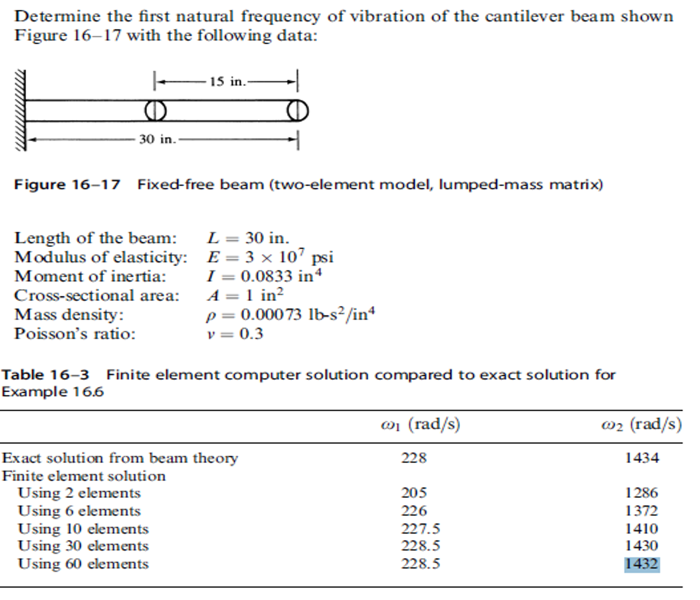

In [44]:
import requests
from PIL import Image
from io import BytesIO

file_id = '1qjfwvsCC8aO4f9SkS3sH9IsJ6aYqwfyd'
url = f'https://drive.google.com/uc?export=view&id={file_id}'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

new_size = (700, 600)  # (largura, altura) em pixels
img_resized = img.resize(new_size)

display(img_resized)
#https://drive.google.com/file/d/1qjfwvsCC8aO4f9SkS3sH9IsJ6aYqwfyd/view?usp=drive_link

In [41]:
import numpy as np
from scipy.linalg import eig

# -----------------------------------------------
# Parâmetros Numéricos (VIGA, Figura 16-17)
# -----------------------------------------------
E = 30e6       # psi (Módulo de Elasticidade)
I = 0.0833     # in^4 (Momento de Inércia)
rho = 0.00073  # lbs-s^2/in^4 (Densidade de Massa)
A = 1.0        # in^2 (Área da Seção Transversal)
L_total = 30.0 # in (Comprimento total da viga)

# Configuração do MEF
num_elementos = 2
num_nos = 3
l_elemento = L_total / num_elementos # l = 15.0 in

# 1. Matrizes do Elemento de Viga (GDL: v1, theta1, v2, theta2)
# Fator de Rigidez (EI/l^3)
EI_l3 = (E * I) / (l_elemento**3)

# Rigidez de Viga [k]
k_elem = np.array([
    [12, 6*l_elemento, -12, 6*l_elemento],
    [6*l_elemento, 4*l_elemento**2, -6*l_elemento, 2*l_elemento**2],
    [-12, -6*l_elemento, 12, -6*l_elemento],
    [6*l_elemento, 2*l_elemento**2, -6*l_elemento, 4*l_elemento**2]
]) * EI_l3

# Matriz de Massa CONCENTRADA [m_elem]
# Apenas termos de translação (v) são preenchidos
rhoAl_2 = (rho * A * l_elemento) / 2
m_elem = np.diag([rhoAl_2, 0, rhoAl_2, 0])


# 2. Montagem Global (6x6)
# GDL globais: v1, theta1, v2, theta2, v3, theta3
num_gdl = num_nos * 2 # 6 GDL
K_global = np.zeros((num_gdl, num_gdl))
M_global = np.zeros((num_gdl, num_gdl))

for e in range(num_elementos):
    idx = e * 2
    K_global[idx:idx+4, idx:idx+4] += k_elem
    M_global[idx:idx+4, idx:idx+4] += m_elem

# 3. Redução (Condições de Contorno: v1=0, theta1=0)
# GDL livres: v2, theta2, v3, theta3 (índices 2, 3, 4, 5 no array Python)
gdl_livres = [2, 3, 4, 5]
K_reduzida = K_global[np.ix_(gdl_livres, gdl_livres)]
M_reduzida = M_global[np.ix_(gdl_livres, gdl_livres)]

# 4. Solução MEF (Encontrando omega)
lambdas, _ = eig(K_reduzida, M_reduzida)
omega_rad_s = np.sort(np.sqrt(np.real(lambdas)))

# 5. Comparação com Tabela 16-3 (Solução Exata e MEF com 2 Elementos)
# Tabela 16-3
omega_1_mef_esperado = 205.0
omega_2_mef_esperado = 1286.0
omega_1_exato = 228.0
omega_2_exato = 1434.0

# -----------------------------------------------
# Resultados
# -----------------------------------------------
print("--- Análise Modal de VIGA (Exemplo 16.6: 2 Elementos, Massa CONCENTRADA) ---")
print(f"L_total={L_total} in, E={E:.2e}, I={I}, rho={rho}")
print("-" * 65)

print("1ª Frequência Natural (omega1):")
print(f"  MEF Concentrada (2 Elem, Código): {omega_rad_s[0]:.2f} rad/s")
print(f"  MEF Concentrada (2 Elem, Tabela): {omega_1_mef_esperado:.1f} rad/s")
print(f"  Analítica Exata (Tabela): {omega_1_exato:.1f} rad/s")

print("-" * 65)

print("2ª Frequência Natural (omega2):")
print(f"  MEF Concentrada (2 Elem, Código): {omega_rad_s[1]:.2f} rad/s")
print(f"  MEF Concentrada (2 Elem, Tabela): {omega_2_mef_esperado:.1f} rad/s")
print(f"  Analítica Exata (Tabela): {omega_2_exato:.1f} rad/s")

print("-" * 65)



--- Análise Modal de VIGA (Exemplo 16.6: 2 Elementos, Massa CONCENTRADA) ---
L_total=30.0 in, E=3.00e+07, I=0.0833, rho=0.00073
-----------------------------------------------------------------
1ª Frequência Natural (omega1):
  MEF Concentrada (2 Elem, Código): 205.19 rad/s
  MEF Concentrada (2 Elem, Tabela): 205.0 rad/s
  Analítica Exata (Tabela): 228.0 rad/s
-----------------------------------------------------------------
2ª Frequência Natural (omega2):
  MEF Concentrada (2 Elem, Código): 1056.93 rad/s
  MEF Concentrada (2 Elem, Tabela): 1286.0 rad/s
  Analítica Exata (Tabela): 1434.0 rad/s
-----------------------------------------------------------------
